In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import tensorboard
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
from sklearn.model_selection import KFold

Using cuda device


In [19]:
transform = transforms.Compose(
            [transforms.Resize([50,50]),transforms.ToTensor(),
             transforms.Normalize(mean=0.5, std=0.5)])

In [20]:
train_dataset = datasets.ImageFolder(root='split_data_breast/train', 
                                     transform=transform)
test_dataset  = datasets.ImageFolder(root='split_data_breast/test',  
                                     transform=transform)
valid_dataset  = datasets.ImageFolder(root='split_data_breast/val',  
                                     transform=transform)

In [21]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 222018
    Root location: split_data_breast/train
    StandardTransform
Transform: Compose(
               Resize(size=[50, 50], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [22]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 27755
    Root location: split_data_breast/test
    StandardTransform
Transform: Compose(
               Resize(size=[50, 50], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [23]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 27751
    Root location: split_data_breast/val
    StandardTransform
Transform: Compose(
               Resize(size=[50, 50], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [24]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [26]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 50, 50])
torch.Size([64])


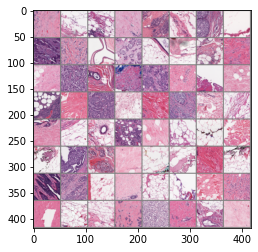

In [27]:
imshow(torchvision.utils.make_grid(images))

In [28]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.to(device)
    size = len(dataloader)
    for i, (X, y) in enumerate(dataloader):
        if torch.cuda.is_available():
            
            #X = X.reshape(1, 3, 224, 224)
            #X = X.float()
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

        # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                loss, current = loss.item(), i * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.to(device)
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    total =0

    with torch.no_grad():
        
        for i, (X, y) in enumerate(dataloader):
            if torch.cuda.is_available():
                
                #X = X.reshape(1, 3, 224, 224)
                #X = X.float()
                X, y = X.to(device), y.to(device)
                pred = model(X)
                total+= y.size(0)
                
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    
    test_loss /= num_batches
    correct /= total
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [29]:
import torch
import torch.nn as nn
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
#alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
#squeezenet = models.squeezenet1_0(pretrained=True)
densenet = models.densenet161(pretrained=True)
#inception = models.inception_v3()

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
for param in resnet18.parameters():
    param.requires_grad = False
    
resnet18.fc = nn.Sequential(nn.Linear(512, 2))

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.01)

epochs = 25
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader,resnet18, loss_fn, optimizer)
    test_loop(test_dataloader, resnet18, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.616746  [    0/ 3470]
loss: 0.358240  [ 6400/ 3470]
loss: 0.861911  [12800/ 3470]
loss: 0.720755  [19200/ 3470]
loss: 0.406820  [25600/ 3470]
loss: 0.541741  [32000/ 3470]
loss: 0.490943  [38400/ 3470]
loss: 0.390197  [44800/ 3470]
loss: 0.562011  [51200/ 3470]
loss: 0.637445  [57600/ 3470]
loss: 0.742365  [64000/ 3470]
loss: 0.504925  [70400/ 3470]
loss: 0.394670  [76800/ 3470]
loss: 0.872935  [83200/ 3470]
loss: 0.653220  [89600/ 3470]
loss: 0.590921  [96000/ 3470]
loss: 0.619943  [102400/ 3470]
loss: 0.356550  [108800/ 3470]
loss: 0.418769  [115200/ 3470]
loss: 0.506806  [121600/ 3470]
loss: 0.552561  [128000/ 3470]
loss: 0.480322  [134400/ 3470]
loss: 0.369432  [140800/ 3470]
loss: 0.647520  [147200/ 3470]
loss: 0.532735  [153600/ 3470]
loss: 0.929317  [160000/ 3470]
loss: 0.245818  [166400/ 3470]
loss: 0.406090  [172800/ 3470]
loss: 0.664127  [179200/ 3470]
loss: 0.532298  [185600/ 3470]
loss: 1.005766  [192000/ 3470]
loss: 0.257819 

In [31]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
for param in vgg16.parameters():
    param.requires_grad = False
    
# vgg16.classifier[3] = nn.Linear(4096,1024)
vgg16.classifier[6] = nn.Linear(4096,2)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.01)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader,vgg16, loss_fn, optimizer)
    test_loop(test_dataloader, vgg16, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.013395  [    0/ 3470]
loss: 1.822205  [ 6400/ 3470]
loss: 1.304111  [12800/ 3470]
loss: 2.096205  [19200/ 3470]
loss: 1.896858  [25600/ 3470]
loss: 1.184813  [32000/ 3470]
loss: 2.082169  [38400/ 3470]
loss: 1.645714  [44800/ 3470]
loss: 1.429286  [51200/ 3470]
loss: 0.713405  [57600/ 3470]
loss: 3.123837  [64000/ 3470]
loss: 2.149529  [70400/ 3470]
loss: 0.984574  [76800/ 3470]
loss: 1.383354  [83200/ 3470]
loss: 3.103323  [89600/ 3470]
loss: 1.584091  [96000/ 3470]
loss: 1.241573  [102400/ 3470]
loss: 1.662576  [108800/ 3470]
loss: 1.994052  [115200/ 3470]
loss: 2.406470  [121600/ 3470]
loss: 2.176581  [128000/ 3470]
loss: 1.440765  [134400/ 3470]
loss: 3.983182  [140800/ 3470]
loss: 2.262719  [147200/ 3470]
loss: 1.543958  [153600/ 3470]
loss: 2.047450  [160000/ 3470]
loss: 1.373242  [166400/ 3470]
loss: 1.651807  [172800/ 3470]
loss: 2.051945  [179200/ 3470]
loss: 2.596298  [185600/ 3470]
loss: 1.425118  [192000/ 3470]
loss: 1.931512 